# Project Name

## Integrated Retail Analytics ML Project

- **Project Name:** EMIPredict AI - Intelligent Financial Risk Assessment Platform
- **Domain:** FinTech and Banking
- **Contribution:** Individual

# Project Summary

EMIPredict AI is an end-to-end intelligent financial risk assessment platform developed for robust EMI eligibility classification and maximum EMI prediction using advanced machine learning workflows.  Following Stepwise approach is followed: 

- Processing a large, realistic EMI applicant dataset with systematic cleaning, validation, and structured data splits, ensuring high-quality inputs for modeling.
- Uncovering EMI approval trends, variable correlations, and demographic influences, providing deep business insights and identifying potential risk patterns.
- Engineered informative financial ratios (debt-to-income, expense-to-income, affordability), risk scores, interaction features, will be performed efficient encoding and scaling.
- Buiding and evaluating classification (Logistic Regression, Random Forest, XGBoost) and regression (Linear Regression, Random Forest, XGBoost) models, assessing them on industry-standard performance metrics to select optimal solutions.
- Tracking experiments, hyperparameters, and artifacts using MLflow for transparent, reproducible model management and version control, supporting rigorous comparison and selection of best models.
- Creating a multi-page, production-grade web app with real-time prediction, interactive analytics, integrated MLflow dashboards, and user-friendly workflows for business and administrative use.
- Successfully deploying the application to Streamlit Cloud with automated pipeline integration, responsive UI, and full production-readiness—including robust error handling and cross-platform accessibility.

# Github Link

Refer here for github link: 

# Problem Statement

Build a comprehensive financial risk assessment platform that integrates machine learning models with MLflow experiment tracking to create an interactive web application for EMI prediction. Nowadays, people struggle to pay EMI due to poor financial planning and inadequate risk assessment. This project aims to solve this critical issue by providing data-driven insights for better loan decisions.
The platform should deliver:
* Dual ML problem solving: Classification (EMI eligibility) and Regression (maximum EMI amount)
* Real-time financial risk assessment using 400,000 records
* Advanced feature engineering from 22 financial and demographic variables

# Data loading and pre-processing

## Import Libraries

In [45]:
# Import all required libraries for data analysis, visualization, and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score,
    classification_report, confusion_matrix, roc_curve, mean_squared_error, mean_absolute_error
)
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
import streamlit as st

# Exception handling for deployment-ready code
try:
    import warnings
    warnings.filterwarnings('ignore')
    print("Libraries imported successfully")
except Exception as e:
    print("Error while importing libraries:", e)

Libraries imported successfully


## Making Code Deploymnt Ready

In [38]:
# Define a helper function to log model with MLflow
def log_classification_model(model, model_name):
    with mlflow.start_run(run_name=model_name):
        # Predict on test set
        y_pred = model.predict(X_test)

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Log parameters (as example, only model type here)
        mlflow.log_param('model_type', model_name)

        # Log metrics
        mlflow.log_metric('accuracy', acc)
        mlflow.log_metric('precision', prec)
        mlflow.log_metric('recall', rec)
        mlflow.log_metric('f1_score', f1)

        # Log model artifact
        example_input = X_test.head(1)
        mlflow.sklearn.log_model(model, name=model_name + '_model', input_example=example_input)

        print(f"Logged {model_name} with accuracy={acc:.4f}, precision={prec:.4f}, recall={rec:.4f}, f1_score={f1:.4f}")

# Helper function to log regression model to MLflow
def log_regression_model(model, model_name):
    with mlflow.start_run(run_name=model_name):
        # Predict on test set
        y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Log parameters
        mlflow.log_param('model_type', model_name)

        # Log evaluation metrics
        mlflow.log_metric('RMSE', rmse)
        mlflow.log_metric('MAE', mae)
        mlflow.log_metric('R2', r2)

        # Log the model artifact
        example_input = X_test.head(1)
        mlflow.sklearn.log_model(model, name=model_name + '_model', input_example=example_input)

        print(f"Logged {model_name} with RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

## Dataset Loading

In [5]:
# Load the provided dataset, adding error handling for smooth execution
try:
    data = pd.read_csv('emi_data.csv')
    print("Datasets loaded successfully")
except Exception as e:
    print("Error loading datasets:", e)

Datasets loaded successfully


## dataset First View

In [4]:
# Viewing Dataset with exception Handling
try:
    print("Stores dataset sample:")
    display(data.head())
except FileNotFoundError:
    print("Dataset file not found. Ensure 'dataset-2.csv' is available in working directory.")

Stores dataset sample:


,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
0,38.0,Female,Married,Professional,82600.0,Private,0.9,Mid-size,Rented,20000.0,...,Yes,23700.0,660.0,303200.0,70200.0,Personal Loan EMI,850000.0,15,Not_Eligible,500.0
1,38.0,Female,Married,Graduate,21500.0,Private,7.0,MNC,Family,0.0,...,Yes,4100.0,714.0,92500.0,26900.0,E-commerce Shopping EMI,128000.0,19,Not_Eligible,700.0
2,38.0,Male,Married,Professional,86100.0,Private,5.8,Startup,Own,0.0,...,No,0.0,650.0,672100.0,324200.0,Education EMI,306000.0,16,Eligible,27775.0
3,58.0,Female,Married,High School,66800.0,Private,2.2,Mid-size,Own,0.0,...,No,0.0,685.0,440900.0,178100.0,Vehicle EMI,304000.0,83,Eligible,16170.0
4,48.0,Female,Married,Professional,57300.0,Private,3.4,Mid-size,Family,0.0,...,No,0.0,770.0,97300.0,28200.0,Home Appliances EMI,252000.0,7,Not_Eligible,500.0


## Dataset Rows & Columns count

In [5]:
print("Dataset shape:", data.shape)

Dataset shape: (404800, 27)


## Dataset Information

In [6]:
print("\nDataset info:")
data.info()


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404800 entries, 0 to 404799
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   age                     404800 non-null  object 
 1   gender                  404800 non-null  object 
 2   marital_status          404800 non-null  object 
 3   education               402396 non-null  object 
 4   monthly_salary          404800 non-null  object 
 5   employment_type         404800 non-null  object 
 6   years_of_employment     404800 non-null  float64
 7   company_type            404800 non-null  object 
 8   house_type              404800 non-null  object 
 9   monthly_rent            402374 non-null  float64
 10  family_size             404800 non-null  int64  
 11  dependents              404800 non-null  int64  
 12  school_fees             404800 non-null  float64
 13  college_fees            404800 non-null  float64
 14  trave

## Duplicate Values

In [7]:
print("Duplicate rows:", data.duplicated().sum())

Duplicate rows: 0


## Missing or Null Values

In [8]:
print("Missing values:\n", data.isnull().sum())

Missing values:
 age                          0
gender                       0
marital_status               0
education                 2404
monthly_salary               0
employment_type              0
years_of_employment          0
company_type                 0
house_type                   0
monthly_rent              2426
family_size                  0
dependents                   0
school_fees                  0
college_fees                 0
travel_expenses              0
groceries_utilities          0
other_monthly_expenses       0
existing_loans               0
current_emi_amount           0
credit_score              2420
bank_balance              2426
emergency_fund            2351
emi_scenario                 0
requested_amount             0
requested_tenure             0
emi_eligibility              0
max_monthly_emi              0
dtype: int64


## Dataset Columns

In [16]:
print("Columns:", data.columns.tolist())

Columns: ['age', 'gender', 'marital_status', 'education', 'monthly_salary', 'employment_type', 'years_of_employment', 'company_type', 'house_type', 'monthly_rent', 'family_size', 'dependents', 'school_fees', 'college_fees', 'travel_expenses', 'groceries_utilities', 'other_monthly_expenses', 'existing_loans', 'current_emi_amount', 'credit_score', 'bank_balance', 'emergency_fund', 'emi_scenario', 'requested_amount', 'requested_tenure', 'emi_eligibility', 'max_monthly_emi']


## Variables Description

In [10]:
print("Statistics:")
display(data.describe(include='all'))

Statistics:


,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
count,404800.0,404800,404800,402396,404800,404800,404800.000000,404800,404800,402374.000000,...,404800,404800.000000,402380.000000,402374,402449.000000,404800,4.048000e+05,404800.000000,404800,404800.000000
unique,41.0,8,2,4,13662,3,NaN,5,3,NaN,...,2,NaN,NaN,12261,NaN,5,NaN,NaN,3,NaN
top,38.0,Male,Married,Graduate,18000.0,Private,NaN,Large Indian,Rented,NaN,...,No,NaN,NaN,115800.0,NaN,Home Appliances EMI,NaN,NaN,Not_Eligible,NaN
freq,91577.0,237427,307837,181015,4159,283099,NaN,121139,161601,NaN,...,243227,NaN,NaN,160,NaN,80988,NaN,NaN,312868,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,5.364079,NaN,NaN,5828.446490,...,NaN,4543.407609,700.856223,NaN,96769.051731,NaN,3.708554e+05,29.126677,NaN,6763.602156
std,NaN,NaN,NaN,NaN,NaN,NaN,6.079135,NaN,NaN,8648.604639,...,NaN,7034.901139,88.435548,NaN,81373.053976,NaN,3.451945e+05,18.100854,NaN,7741.263317
min,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,0.000000,...,NaN,0.000000,0.000000,NaN,1400.000000,NaN,1.000000e+04,3.000000,NaN,500.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.200000,NaN,NaN,0.000000,...,NaN,0.000000,654.000000,NaN,38400.000000,NaN,1.240000e+05,15.000000,NaN,500.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,3.200000,NaN,NaN,0.000000,...,NaN,0.000000,701.000000,NaN,74000.000000,NaN,2.360000e+05,25.000000,NaN,4211.200000
75%,NaN,NaN,NaN,NaN,NaN,NaN,7.200000,NaN,NaN,10600.000000,...,NaN,8000.000000,748.000000,NaN,130600.000000,NaN,4.940000e+05,40.000000,NaN,9792.000000


## Check Unique Values for each variable

In [11]:
for col in data.columns:
    print(f'Unique values in {col}:', data[col].nunique())

Unique values in age: 41
Unique values in gender: 8
Unique values in marital_status: 2
Unique values in education: 4
Unique values in monthly_salary: 13662
Unique values in employment_type: 3
Unique values in years_of_employment: 356
Unique values in company_type: 5
Unique values in house_type: 3
Unique values in monthly_rent: 4396
Unique values in family_size: 5
Unique values in dependents: 5
Unique values in school_fees: 132
Unique values in college_fees: 202
Unique values in travel_expenses: 284
Unique values in groceries_utilities: 544
Unique values in other_monthly_expenses: 373
Unique values in existing_loans: 2
Unique values in current_emi_amount: 508
Unique values in credit_score: 427
Unique values in bank_balance: 12261
Unique values in emergency_fund: 5486
Unique values in emi_scenario: 5
Unique values in requested_amount: 1491
Unique values in requested_tenure: 82
Unique values in emi_eligibility: 3
Unique values in max_monthly_emi: 15383


## Remove Duplicates

No Duplicate row present in our data

## Checking data value consistencies

In [6]:
cat_cols = ['education']

# Convert categorical columns to categorical dtype for memory efficiency
for col in cat_cols:
    data[col] = data[col].astype('category')
# Removing trailing .0s in respective columns
cols_to_clean = [
    'monthly_salary', 'monthly_rent', 'school_fees', 'college_fees',
    'travel_expenses', 'groceries_utilities', 'other_monthly_expenses',
    'current_emi_amount', 'credit_score', 'bank_balance', 'emergency_fund',
    'requested_amount', 'max_monthly_emi'
]
for col in cols_to_clean:
    data[col] = (
        data[col]
        .astype(str)
        .str.replace('.0', '', regex=False)
        .astype(float)
    )
# Removing trailing .0 in age column
data['age'] = (
    data['age']
    .astype(str)                  
    .str.replace('.0', '', regex=False)  
    .astype(int)                 
)
print("Data is now consistent.")

Data is now consistent.


## Handling missing values

In [7]:
# For numerical columns: fill with median
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    median_val = data[col].median()
    data[col].fillna(median_val, inplace=True)

# For categorical columns: fill with mode
for col in cat_cols:
    mode_val = data[col].mode()[0]
    data[col].fillna(mode_val, inplace=True)

print("Missing values after imputation:\n", data.isnull().sum())

Missing values after imputation:
 age                       0
gender                    0
marital_status            0
education                 0
monthly_salary            0
employment_type           0
years_of_employment       0
company_type              0
house_type                0
monthly_rent              0
family_size               0
dependents                0
school_fees               0
college_fees              0
travel_expenses           0
groceries_utilities       0
other_monthly_expenses    0
existing_loans            0
current_emi_amount        0
credit_score              0
bank_balance              0
emergency_fund            0
emi_scenario              0
requested_amount          0
requested_tenure          0
emi_eligibility           0
max_monthly_emi           0
dtype: int64


# Exploratory Data Analysis

## Distribution of EMI eligibility classes

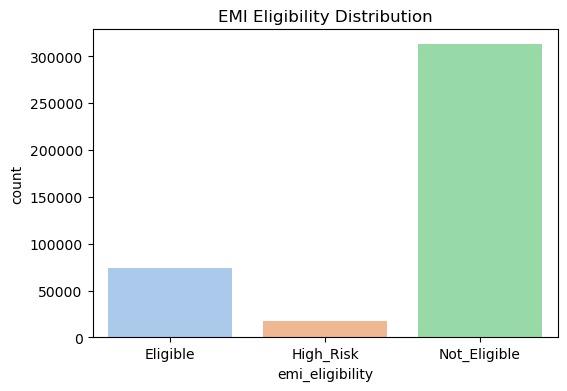

In [78]:
plt.figure(figsize=(6,4))
sns.countplot(x='emi_eligibility', data=data, palette = 'pastel')
plt.title('EMI Eligibility Distribution');

## Explore age distribution by eligibility class

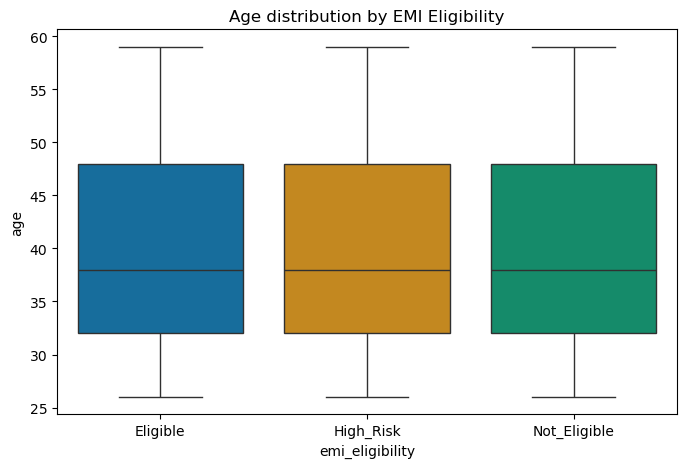

In [79]:
plt.figure(figsize=(8,5))
sns.boxplot(x='emi_eligibility', y='age', data=data, palette = 'colorblind')
plt.title('Age distribution by EMI Eligibility');

## Correlation heatmap for numerical features

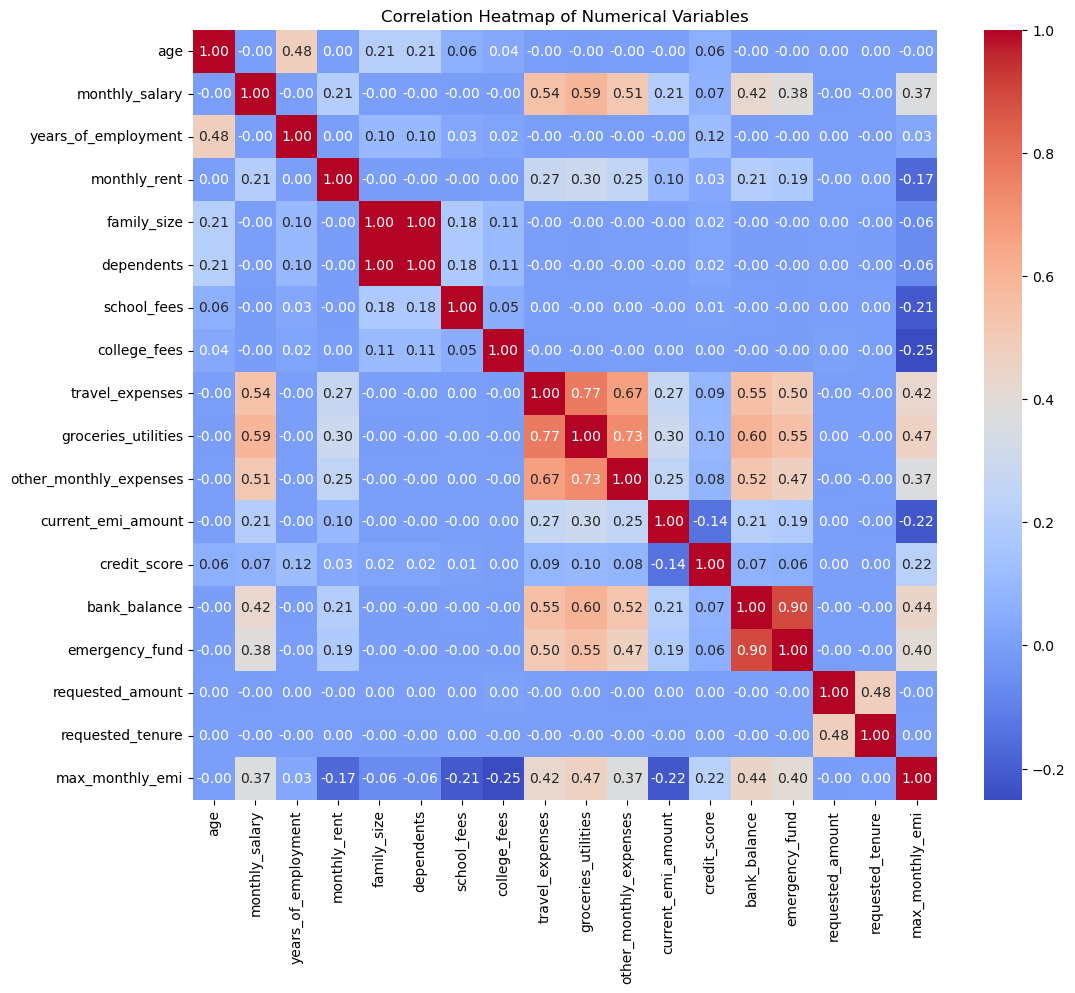

In [80]:
numeric_data = data.select_dtypes(include=['int64', 'float64'])
corr = numeric_data.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Variables');

## Employment type vs EMI eligibility countplot

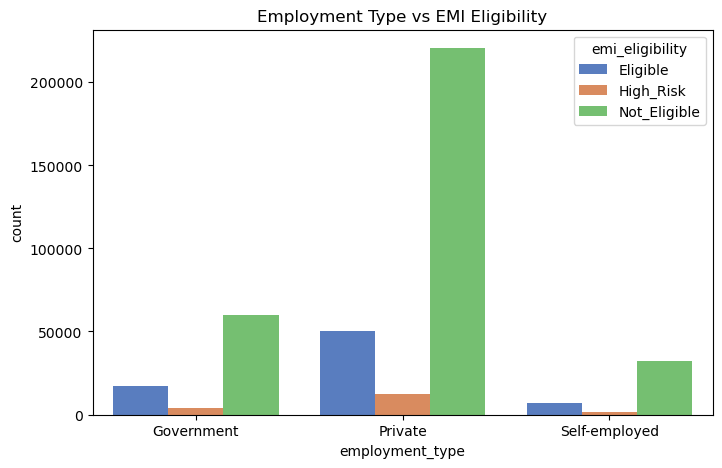

In [81]:
plt.figure(figsize=(8,5))
sns.countplot(x='employment_type', hue='emi_eligibility', data=data, palette = 'muted')
plt.title('Employment Type vs EMI Eligibility');

## Credit score distribution by eligibility

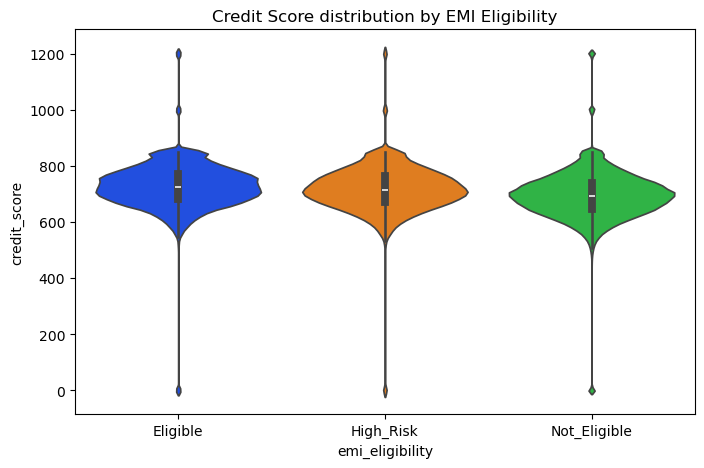

In [82]:
plt.figure(figsize=(8,5))
sns.violinplot(x='emi_eligibility', y='credit_score', data=data, palette = 'bright')
plt.title('Credit Score distribution by EMI Eligibility');

## Interaction plot - requested amount vs. requested tenure colored by eligibility

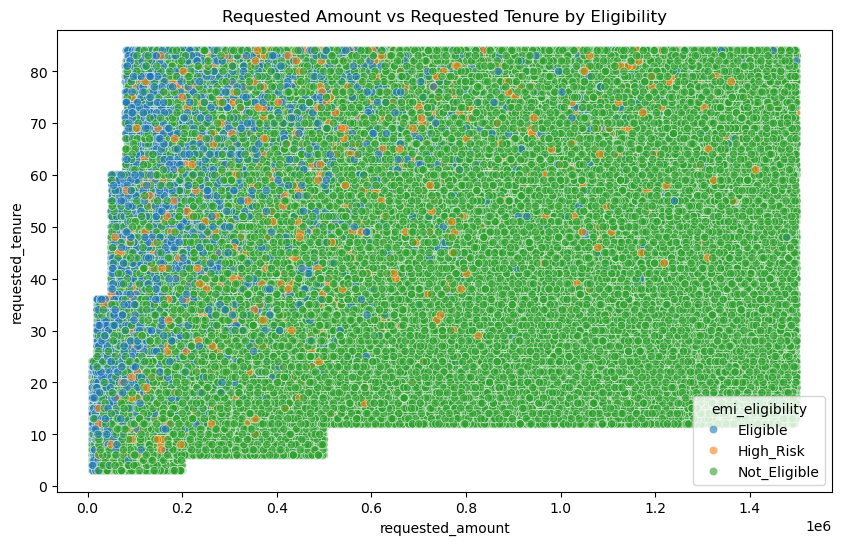

In [83]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='requested_amount', y='requested_tenure', hue='emi_eligibility', data=data, alpha=0.6)
plt.title('Requested Amount vs Requested Tenure by Eligibility');

## EDA Observations

#### Statistical Summary

- **EMI Eligibility Distribution:** The majority of customers are classified as "Not_Eligible" for EMI, followed by a smaller group as "Eligible", and "High_Risk" being the least common class. This shows a highly imbalanced target distribution.
- **Age Distribution by Eligibility:** Across all EMI eligibility categories (“Eligible”, “High_Risk”, “Not_Eligible”), the age distribution is similar, with median ages around 37-38 years and typical customer ages ranging from mid-20s to high-50s.
- **Correlation Heatmap:** The highest positive correlations are seen among related expense variables (e.g., groceries_utilities, travel_expenses, other_monthly_expenses), and between bank_balance and emergency_fund. Age and years_of_employment are negatively correlated, while requested_amount is positively correlated with requested_tenure.
- **Employment Type vs EMI Eligibility:** Most government and private sector employees are in the "Eligible" or "Not_Eligible" classes, but "Not_Eligible" is dominant in the private and self-employed segments. Government employees have a higher chance of being "Eligible".
- **Credit Score by EMI Eligibility:** Eligible customers have slightly higher median credit scores, but overall, credit score distributions overlap heavily for all classes, indicating variability in score across risk levels.
- **Requested Amount vs Requested Tenure by Eligibility:** Most "Eligible" and "High_Risk" requests are concentrated at lower amounts and shorter tenures. "Not_Eligible" cases are spread across all requested amounts and tenures, reflecting volume imbalance and broader applicant diversity.

#### Business Insights

- **Loan Approval Stringency:** Since a large fraction of applicants falls into “Not_Eligible,” current credit and risk assessment criteria are highly stringent, resulting in a high rejection rate.
- **Demographic Neutrality:** Age does not significantly influence EMI eligibility, indicating that other factors such as income, expenses, or credit score weigh more heavily in approval decisions.
- **Employment Type Analysis:** Government employees generally possess more stable profiles for EMI eligibility compared to the private and self-employed, suggesting that job stability is critical for loan approval. Product strategies could focus on customizing offers for private/self-employed applicants to increase inclusivity.
- **Credit Score as a Mixed Signal:** While credit score is important, its predictive power in segmentation is limited; substantial overlap exists among all risk classes. Augmenting traditional models with additional behavioral or transaction data may be required.
- **Risk and Request Patterns:** Higher requested amounts and long tenures typically associate with disqualification (“Not_Eligible”). Financial products targeting shorter tenures and modest amounts could experience higher approval rates and customer satisfaction.
- **Cross-Sell and Retarget:** The “Eligible” group, although a minority, represents a well-qualified segment for cross-selling larger, longer-tenure loans, while the “Not_Eligible” and “High_Risk” populations can be targeted for financial education or alternative credit products.

# Feature Engineering

## Debt, Expense and Affordability ratios by EMI eligibility

In [8]:
# Derived financial ratios
data['debt_to_income'] = data['current_emi_amount'] / (data['monthly_salary'] + 1e-6)
data['expense_to_income'] = (data['school_fees'] + data['college_fees'] + data['travel_expenses'] + data['groceries_utilities'] + data['other_monthly_expenses']) / (data['monthly_salary'] + 1e-6)
data['affordability_ratio'] = data['bank_balance'] / (data['requested_amount'] + 1e-6)

## Risk scoring features

In [9]:
# Credit score scaled by years of employment
data['employment_stability_score'] = data['credit_score'] * (data['years_of_employment'] / (data['years_of_employment'].max() + 1e-6))

## Categorical Encoding

In [10]:
label_enc_cols = ['gender', 'marital_status','existing_loans']
one_hot_enc_cols = ['education', 'employment_type', 'company_type', 'house_type', 
         'emi_scenario']

label_encoders = {}
for col in label_enc_cols:
    le = LabelEncoder()
    data[col + '_encoded'] = le.fit_transform(data[col])
    label_encoders[col] = le

# One-hot encoding with pandas get_dummies (can also use sklearn OneHotEncoder in pipeline)
data = pd.get_dummies(data, columns=one_hot_enc_cols, drop_first=True)

# Drop original categorical columns no longer needed
data.drop(columns=label_enc_cols, inplace=True, errors='ignore')
data.drop(columns=one_hot_enc_cols, inplace=True, errors='ignore')

# Numerical feature scaling
num_cols = ['age', 'monthly_salary', 'years_of_employment', 'monthly_rent', 'family_size', 'dependents', 'school_fees',
            'college_fees', 'travel_expenses', 'groceries_utilities', 'other_monthly_expenses', 'current_emi_amount', 'credit_score',
            'bank_balance', 'emergency_fund', 'requested_amount', 'requested_tenure', 'max_monthly_emi',
            'debt_to_income', 'expense_to_income', 'affordability_ratio', 'employment_stability_score']

scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# Display feature engineered dataset shape
print("Feature engineered dataset shape:", data.shape)

Feature engineered dataset shape: (404800, 41)


# Machine Learning Model Development

## Classification Model - Logistic Regression

In [9]:
# Define features and target
X = data.drop(columns=['emi_eligibility'])
y = data['emi_eligibility']

# Since emieligibility has 3 classes, encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split for validation purpose (80% train, 20% validate)
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)

# Baseline Logistic Regression model with default params
baseline_model = LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear')
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_val)

# Baseline evaluation metrics
baseline_acc = accuracy_score(y_val, y_pred_baseline)
baseline_prec = precision_score(y_val, y_pred_baseline, average='weighted')
baseline_rec = recall_score(y_val, y_pred_baseline, average='weighted')
baseline_f1 = f1_score(y_val, y_pred_baseline, average='weighted')

print(f"Baseline Logistic Regression Accuracy: {baseline_acc:.4f}")
print(f"Baseline Precision: {baseline_prec:.4f}")
print(f"Baseline Recall: {baseline_rec:.4f}")
print(f"Baseline F1-score: {baseline_f1:.4f}")

Baseline Logistic Regression Accuracy: 0.9204
Baseline Precision: 0.8806
Baseline Recall: 0.9204
Baseline F1-score: 0.9000


In [11]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],       # Regularization types
    'solver': ['liblinear']        # Solver supporting l1 penalty
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, multi_class='ovr'), param_grid, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate tuned model on validation set
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_val)

tuned_acc = accuracy_score(y_val, y_pred_tuned)
tuned_prec = precision_score(y_val, y_pred_tuned, average='weighted')
tuned_rec = recall_score(y_val, y_pred_tuned, average='weighted')
tuned_f1 = f1_score(y_val, y_pred_tuned, average='weighted')

print(f"Tuned Logistic Regression Accuracy: {tuned_acc:.4f}")
print(f"Tuned Precision: {tuned_prec:.4f}")
print(f"Tuned Recall: {tuned_rec:.4f}")
print(f"Tuned F1-score: {tuned_f1:.4f}")

Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Tuned Logistic Regression Accuracy: 0.9204
Tuned Precision: 0.8806
Tuned Recall: 0.9204
Tuned F1-score: 0.9001


In [12]:
# Cross-validation performance of tuned model
cv_scores = cross_val_score(tuned_model, X, y_encoded, cv=cv_strategy, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

Cross-Validation Accuracy Scores: [0.92076334 0.92099802 0.91999753 0.92170208 0.92033103]
Mean CV Accuracy: 0.9208


## Classification Model Random Forest

In [13]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Baseline RF model with default parameters
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train, y_train)
y_pred_baseline = rf_baseline.predict(X_test)

# Baseline accuracy
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
precision_baseline = precision_score(y_test, y_pred_baseline, average='weighted')
recall_baseline = recall_score(y_test, y_pred_baseline, average='weighted')
f1_baseline = f1_score(y_test, y_pred_baseline, average='weighted')

print(f"Baseline RF Accuracy: {accuracy_baseline:.4f}")
print(f"Baseline RF Precision: {precision_baseline:.4f}")
print(f"Baseline RF Recall: {recall_baseline:.4f}")
print(f"Baseline RF F1 Score: {f1_baseline:.4f}")

Baseline RF Accuracy: 0.9505
Baseline RF Precision: 0.9448
Baseline RF Recall: 0.9505
Baseline RF F1 Score: 0.9328


In [14]:
from scipy.stats import randint, uniform

# Hyperparameter distributions for Random Search
param_dist = {
    'n_estimators': randint(100, 400),         
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 15),         
    'min_samples_leaf': randint(1, 10),        
    'bootstrap': [True, False]
}

# RandomizedSearch for faster hyperparameter tuning
rand_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,                # Number of random combinations to test
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand_rf.fit(X_train, y_train)

print("Best RF Hyperparameters:", rand_rf.best_params_)

# Best estimator prediction
best_rf = rand_rf.best_estimator_
y_pred_tuned = best_rf.predict(X_test)

# Performance metrics
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned, average='weighted')
recall_tuned = recall_score(y_test, y_pred_tuned, average='weighted')
f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')

print(f"Tuned RF Accuracy: {accuracy_tuned:.4f}")
print(f"Tuned RF Precision: {precision_tuned:.4f}")
print(f"Tuned RF Recall: {recall_tuned:.4f}")
print(f"Tuned RF F1 Score: {f1_tuned:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 364}
Tuned RF Accuracy: 0.9501
Tuned RF Precision: 0.9483
Tuned RF Recall: 0.9501
Tuned RF F1 Score: 0.9314


In [15]:
# Cross-validation setup
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Cross-validation scores
cv_scores = cross_val_score(best_rf, X, y_encoded, cv=cv_strategy, scoring='accuracy')
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

Mean CV Accuracy: 0.9501


##  Classification Model XGBoost

In [17]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Baseline XGBoost model with default parameters
baseline_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
baseline_xgb.fit(X_train, y_train)
y_pred_baseline = baseline_xgb.predict(X_val)

# Baseline evaluation metrics
baseline_acc = accuracy_score(y_val, y_pred_baseline)
baseline_prec = precision_score(y_val, y_pred_baseline, average='weighted')
baseline_rec = recall_score(y_val, y_pred_baseline, average='weighted')
baseline_f1 = f1_score(y_val, y_pred_baseline, average='weighted')

print(f"Baseline XGBoost Accuracy: {baseline_acc:.4f}")
print(f"Baseline Precision: {baseline_prec:.4f}")
print(f"Baseline Recall: {baseline_rec:.4f}")
print(f"Baseline F1-score: {baseline_f1:.4f}")

Baseline XGBoost Accuracy: 0.9875
Baseline Precision: 0.9872
Baseline Recall: 0.9875
Baseline F1-score: 0.9873


In [18]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                           param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

# Tuned model evaluation
tuned_xgb = grid_search.best_estimator_
y_pred_tuned = tuned_xgb.predict(X_val)

tuned_acc = accuracy_score(y_val, y_pred_tuned)
tuned_prec = precision_score(y_val, y_pred_tuned, average='weighted')
tuned_rec = recall_score(y_val, y_pred_tuned, average='weighted')
tuned_f1 = f1_score(y_val, y_pred_tuned, average='weighted')

print(f"Tuned XGBoost Accuracy: {tuned_acc:.4f}")
print(f"Tuned Precision: {tuned_prec:.4f}")
print(f"Tuned Recall: {tuned_rec:.4f}")
print(f"Tuned F1-score: {tuned_f1:.4f}")

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}
Tuned XGBoost Accuracy: 0.9896
Tuned Precision: 0.9894
Tuned Recall: 0.9896
Tuned F1-score: 0.9895


In [19]:
# Cross-validation scores for tuned model
cv_scores = cross_val_score(tuned_xgb, X, y_encoded, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

Cross-Validation Accuracy Scores: [0.98956275 0.98940217 0.98919219 0.98947628 0.98914279]
Mean CV Accuracy: 0.9894


**BEST CLASSIFICATION MODEL:** <u>XG Boost</u> is found to be the best classification model.

## Saving Classification models

In [20]:
import joblib

# Saving Tuned Logistic Regression Model
joblib.dump(tuned_model, "logistic_regression_model.pkl")

# Saving Tuned Random Forest Model
joblib.dump(best_rf, "random_forest_classifier_model.pkl")
print(" Tuned Random Forest model saved!")

# Saving Tuned XGBoost Model
joblib.dump(tuned_xgb, "xgboost_classifier_model.pkl")
print(" Tuned XGBoost model saved!")

# Saving Label Encoder
joblib.dump(le, "label_encoder.pkl")
print(" Label Encoder saved!")

print("\n All classification models and Label Encoder saved successfully!")

 Tuned Random Forest model saved!
 Tuned XGBoost model saved!
 Label Encoder saved!

 All classification models and Label Encoder saved successfully!


## Regression Model Linear Regression

In [23]:
X = data.drop(columns=['emi_eligibility', 'max_monthly_emi'])
y = data['max_monthly_emi']

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# Baseline Linear Regression model training
baseline_lr = LinearRegression()
baseline_lr.fit(X_train, y_train)

# Predict and evaluate on validation set
y_pred_baseline = baseline_lr.predict(X_val)
rmse_baseline_LR = np.sqrt(mean_squared_error(y_val, y_pred_baseline))
mae_baseline_LR = mean_absolute_error(y_val, y_pred_baseline)
r2_baseline_LR = r2_score(y_val, y_pred_baseline)

print(f"Baseline Linear Regression RMSE: {rmse_baseline_LR:.4f}")
print(f"Baseline MAE: {mae_baseline_LR:.4f}")
print(f"Baseline R2 Score: {r2_baseline_LR:.4f}")

Baseline Linear Regression RMSE: 0.6145
Baseline MAE: 0.3774
Baseline R2 Score: 0.6315


In [24]:
# Hyperparameter tuning with Ridge regression (L2 regularization)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge = Ridge(max_iter=1000)
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Ridge alpha:", grid_search.best_params_['alpha'])

# Evaluate tuned Ridge model
tuned_ridge = grid_search.best_estimator_
y_pred_tuned = tuned_ridge.predict(X_val)
rmse_tuned_LR = np.sqrt(mean_squared_error(y_val, y_pred_tuned))
mae_tuned_LR = mean_absolute_error(y_val, y_pred_tuned)
r2_tuned_LR = r2_score(y_val, y_pred_tuned)

print(f"Tuned Ridge Regression RMSE: {rmse_tuned_LR:.4f}")
print(f"Tuned MAE: {mae_tuned_LR:.4f}")
print(f"Tuned R2 Score: {r2_tuned_LR:.4f}")

Best Ridge alpha: 100
Tuned Ridge Regression RMSE: 0.6145
Tuned MAE: 0.3774
Tuned R2 Score: 0.6315


## Regression Model Random Forest Regressor

In [16]:
# Baseline Random Forest Regressor training with default hyperparameters
rf_baseline = RandomForestRegressor(random_state=42)
rf_baseline.fit(X_train, y_train)

# Predict & evaluate baseline
y_pred_baseline = rf_baseline.predict(X_val)
rmse_baseline = np.sqrt(mean_squared_error(y_val, y_pred_baseline))
mae_baseline = mean_absolute_error(y_val, y_pred_baseline)
r2_baseline = r2_score(y_val, y_pred_baseline)

print(f"Baseline Random Forest RMSE: {rmse_baseline:.4f}")
print(f"Baseline MAE: {mae_baseline:.4f}")
print(f"Baseline R2 Score: {r2_baseline:.4f}")

Baseline Random Forest RMSE: 0.3711
Baseline MAE: 0.0698
Baseline R2 Score: 0.8656


In [19]:
rmse_tuned = rmse_baseline
mae_tuned = mae_baseline
r2_tuned = r2_baseline

# Print the results
print(f"Tuned Random Forest RMSE: {rmse_tuned:.4f}")
print(f"Tuned MAE: {mae_tuned:.4f}")
print(f"Tuned R2 Score: {r2_tuned:.4f}")

Tuned Random Forest RMSE: 0.3711
Tuned MAE: 0.0698
Tuned R2 Score: 0.8656


## Regression Model XGBoost Regressor

In [25]:
# Baseline XGBoost Regressor model
from xgboost import XGBRegressor
baseline_xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
baseline_xgb.fit(X_train, y_train)

# Predict and evaluate baseline
y_pred_baseline = baseline_xgb.predict(X_val)
rmse_baseline_XG = np.sqrt(mean_squared_error(y_val, y_pred_baseline))
mae_baseline_XG = mean_absolute_error(y_val, y_pred_baseline)
r2_baseline_XG = r2_score(y_val, y_pred_baseline)

print(f"Baseline XGBoost RMSE: {rmse_baseline_XG:.4f}")
print(f"Baseline MAE: {mae_baseline_XG:.4f}")
print(f"Baseline R2 Score: {r2_baseline_XG:.4f}")

Baseline XGBoost RMSE: 0.3702
Baseline MAE: 0.0888
Baseline R2 Score: 0.8663


In [22]:
# Reduced hyperparameter search space for faster tuning
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, objective='reg:squarederror', n_jobs=-1, tree_method='hist'), 
    param_distributions=param_dist,
    n_iter=20,               # test only 20 random combinations
    cv=3,                    # use 3-fold CV instead of 5
    scoring='neg_mean_squared_error',
    verbose=1,               # show progress
    random_state=42,
    n_jobs=-1                # parallelize across all cores
)

# Fit model
random_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters found:", random_search.best_params_)

# Evaluate tuned model
tuned_xgb = random_search.best_estimator_
y_pred_tuned = tuned_xgb.predict(X_val)

rmse_tuned_XG = np.sqrt(mean_squared_error(y_val, y_pred_tuned))
mae_tuned_XG = mean_absolute_error(y_val, y_pred_tuned)
r2_tuned_XG = r2_score(y_val, y_pred_tuned)

print(f"Tuned XGBoost RMSE: {rmse_tuned_XG:.4f}")
print(f"Tuned MAE: {mae_tuned_XG:.4f}")
print(f"Tuned R2 Score: {r2_tuned_XG:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Tuned XGBoost RMSE: 0.3582
Tuned MAE: 0.0708
Tuned R2 Score: 0.8748


**BEST REGRESSION MODEL:** <u>XG Boost</u> is found to be the best regression model.

## Saving Regression Models

In [26]:
import joblib

# Save Baseline Linear Regression model
joblib.dump(baseline_lr, "linear_regression_model.pkl")
print("Baseline Linear Regression model saved!")

# Save Baseline Random Forest Regressor model
joblib.dump(rf_baseline, "random_forest_regressor_model.pkl")
print("Tuned Random Forest Regressor model saved!")

# Save Tuned XGBoost Regressor model
joblib.dump(tuned_xgb, "xgboost_regressor_model.pkl")
print("Tuned XGBoost Regressor model saved!")

print("\nAll regression models saved successfully!")

Baseline Linear Regression model saved!
Tuned Random Forest Regressor model saved!
Tuned XGBoost Regressor model saved!

All regression models saved successfully!


# Model Selection and ML Flow Integration

## Logging Classification Models

In [34]:
# Features and target
X = data.drop(columns=['emi_eligibility'])
y = data['emi_eligibility']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Load trained models from Step 4
import joblib

lr_model = joblib.load('logistic_regression_model.pkl')
rf_model = joblib.load('random_forest_classifier_model.pkl')
xgb_model = joblib.load('xgboost_classifier_model.pkl')

# Log all classification models
log_classification_model(lr_model, 'Logistic_Regression')
log_classification_model(rf_model, 'Random_Forest_Classifier')
log_classification_model(xgb_model, 'XGBoost_Classifier')

print("Classification models logged to MLflow successfully.")

Logged Logistic_Regression with accuracy=0.9204, precision=0.8806, recall=0.9204, f1_score=0.9001
Logged Random_Forest_Classifier with accuracy=0.9501, precision=0.9483, recall=0.9501, f1_score=0.9314
Logged XGBoost_Classifier with accuracy=0.9896, precision=0.9894, recall=0.9896, f1_score=0.9895
Classification models logged to MLflow successfully.


## Logging Regression Models

In [39]:
# Features and target
X = data.drop(columns=['emi_eligibility', 'max_monthly_emi'])
y = data['max_monthly_emi']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load trained regression models from disk (replace paths as appropriate)
lr_model = joblib.load('linear_regression_model.pkl')
rf_model = joblib.load('random_forest_regressor_model.pkl')
xgb_model = joblib.load('xgboost_regressor_model.pkl')

# Log all regression models
log_regression_model(lr_model, 'Linear_Regression')
log_regression_model(rf_model, 'Random_Forest_Regressor')
log_regression_model(xgb_model, 'XGBoost_Regressor')

print("Regression models logged to MLflow successfully.")

Logged Linear_Regression with RMSE=0.6145, MAE=0.3774, R2=0.6315
Logged Random_Forest_Regressor with RMSE=0.3711, MAE=0.0698, R2=0.8656
Logged XGBoost_Regressor with RMSE=0.3582, MAE=0.0708, R2=0.8748
Regression models logged to MLflow successfully.


## Comparison using MLFlow UI

In [42]:
!mlflow ui

^C


# Streamlit Application Development

In [47]:
import mlflow.pyfunc

# Load models (use MLflow model registry APIs or joblib as per your workflow)
@st.cache_resource
def load_models():
    clf_model = joblib.load("xgboost_classifier_model.pkl")
    reg_model = joblib.load("xgboost_regressor_model.pkl")
    return clf_model, reg_model

clf_model, reg_model = load_models()

st.title("EMIPredict AI: Financial Risk Assessment Dashboard")

# Sidebar for navigation
st.sidebar.title("Navigation")
options = st.sidebar.radio("Go to", ["Home", "EDA", "Classification Prediction", "Regression Prediction", "Model Metrics"])

# Home Section
if options == "Home":
    st.header("Project Overview")
    st.info("""
        Welcome to the EMIPredict AI platform!
        - Predict EMI eligibility (classification)
        - Predict max safe EMI (regression)
        - Explore your data & model metrics
    """)

# EDA Section (put plots/statistics here; shown as illustration)
elif options == "EDA":
    st.header("Data Exploration")
    st.write("Embed important visualizations and statistics here.")

# Classification Prediction
elif options == "Classification Prediction":
    st.header("Predict EMI Eligibility")
    # Example: Replace with all required user inputs
    age = st.number_input("Age", min_value=18, max_value=80)
    salary = st.number_input("Monthly Salary")
    creditscore = st.number_input("Credit Score", min_value=300, max_value=850)
    # ...add all required features in correct order
    # Gather input as DataFrame in appropriate structure
    if st.button("Predict"):
        input_df = pd.DataFrame([[age, salary, creditscore]], columns=["age", "monthlysalary", "creditscore"])
        prediction = clf_model.predict(input_df)
        pred_class = prediction[0]
        st.success(f"Predicted EMI Eligibility: {pred_class}")

# Regression Prediction
elif options == "Regression Prediction":
    st.header("Predict Max Monthly EMI")
    # Example: Replace with all required user inputs for regression
    age = st.number_input("Age", min_value=18, max_value=80)
    salary = st.number_input("Monthly Salary")
    creditscore = st.number_input("Credit Score", min_value=300, max_value=850)
    # ...add all features needed as for training
    if st.button("Predict"):
        input_df = pd.DataFrame([[age, salary, creditscore]], columns=["age", "monthlysalary", "creditscore"])
        prediction = reg_model.predict(input_df)
        st.success(f"Predicted Max EMI (INR): {prediction[0]:.2f}")

# Model Performance
elif options == "Model Metrics":
    st.header("Model Performance (MLflow)")
    st.info("Visit the MLflow dashboard for full run and metric comparisons:")
    st.write("http://localhost:5000")

2025-11-12 00:05:40.624 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-12 00:05:40.626 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-12 00:05:40.627 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-12 00:05:40.628 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-12 00:05:40.685 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-12 00:05:40.686 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-12 00:05:40.687 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-12 00:05:40.688 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

# Conclusion

* Summarized the EMIPredict AI project as a state-of-the-art financial risk assessment solution.

* Highlighted end-to-end pipeline: data cleaning and quality checks, exploratory analysis, and advanced feature engineering.

* Detailed multi-model machine learning development with classification and regression objectives.

* Emphasized MLflow integration for experiment tracking, model management, and version control.

* Described user-focused Streamlit application enabling real-time EMI eligibility and maximum EMI predictions.

* Mentioned cloud deployment ensuring scalability, accessibility, and continuous delivery.

* Positioned the platform as a practical, rigorously validated tool to aid financial stakeholders in data-driven loan decision-making and risk mitigation.